# CS933 Image & Video Analysis coursework 2023-2024, Part 2
> ID: 5556162, Name: Tien Yu Lin

## Module imports

In [1]:
import multiprocessing as mp

import cv2
import numpy as np
from matplotlib import pyplot as plt

from lib.public import db, show_images_in_row, find_single_components_in, rotate_img_by_angle

## Read origin images

In [2]:
board1s = tuple(
    cv2.imread(f'{db.boards_dir}/BOARD1-{i + 1}.jpg')
    for i in range(3)
)

board2s = tuple(
    cv2.imread(f'{db.boards_dir}/BOARD2-{i + 1}.jpg')
    for i in range(3)
)

board3s = tuple(
    cv2.imread(f'{db.boards_dir}/BOARD3-{i + 1}.jpg')
    for i in range(3)
)

## Cleanup background to get only the board, make background white

In [3]:
# Enable this to always calculate components in each board, instead of using cache.
# Warning: This will take a long time to run.
force_run_component_finding = False

In [4]:
cache_existence = tuple(
    db.check_if_file_exists(f'{db.boards_dir}/board{i + 1}_single_{j}.jpg')
    for i in range(3) for j in range(3)
)

bin_cache_existence = tuple(
    db.check_if_file_exists(f'{db.boards_dir}/b_board{i + 1}_single_{j}.jpg')
    for i in range(3) for j in range(3)
)

should_find_components = (
        force_run_component_finding or
        not all(cache_existence) or
        not all(bin_cache_existence)
)

In [5]:
bg_threshold_1 = 140
bg_threshold_2 = 130
bg_threshold_3 = 130

board1_singles = []
b_board1_singles = []

board2_singles = []
b_board2_singles = []

board3_singles = []
b_board3_singles = []

In [6]:
def find_components_in_each_board_img():
    with mp.Pool(processes=9) as pool:
        async_results_board1 = []
        async_results_board2 = []
        async_results_board3 = []

        print('Start finding single components in board1, board2, board3... (this may take a while, maybe 3m)')

        for board1, board2, board3 in zip(board1s, board2s, board3s):
            # Separate finding process to different processes
            async_results_board1.append(pool.apply_async(
                find_single_components_in, (board1, bg_threshold_1)
            ))
            async_results_board2.append(pool.apply_async(
                find_single_components_in, (board2, bg_threshold_2, 1500)
            ))
            async_results_board3.append(pool.apply_async(
                find_single_components_in, (board3, bg_threshold_3, 1500)
            ))

        # Get results
        async_results_board1 = [async_result.get() for async_result in async_results_board1]
        async_results_board2 = [async_result.get() for async_result in async_results_board2]
        async_results_board3 = [async_result.get() for async_result in async_results_board3]

        # Wait until all processes finish
        pool.close()
        pool.join()

        # Append to list
        for t1, t2, t3 in zip(
                async_results_board1, async_results_board2, async_results_board3
        ):
            board1_single_components, b_board1_single_components = t1
            board2_single_components, b_board2_single_components = t2
            board3_single_components, b_board3_single_components = t3

            # Since there's only one component in each image, we need to find the largest one
            largest_board1_component_index = np.argmax([
                component.shape[0]
                for component in board1_single_components
            ])
            largest_board2_component_index = np.argmax([
                component.shape[0]
                for component in board2_single_components
            ])
            largest_board3_component_index = np.argmax([
                component.shape[0]
                for component in board3_single_components
            ])

            board1_singles.append(board1_single_components[largest_board1_component_index])
            b_board1_singles.append(b_board1_single_components[largest_board1_component_index])

            board2_singles.append(board2_single_components[largest_board2_component_index])
            b_board2_singles.append(b_board2_single_components[largest_board2_component_index])

            board3_singles.append(board3_single_components[largest_board3_component_index])
            b_board3_singles.append(b_board3_single_components[largest_board3_component_index])

        # Save images for cache
        for i, (board1_single, board2_single, board3_single) in enumerate(zip(
                board1_singles, board2_singles, board3_singles
        )):
            cv2.imwrite(
                f'{db.boards_dir}/board1_single_{i}.jpg',
                cv2.cvtColor(board1_single, cv2.COLOR_RGB2BGR)
            )
            cv2.imwrite(
                f'{db.boards_dir}/board2_single_{i}.jpg',
                cv2.cvtColor(board2_single, cv2.COLOR_RGB2BGR)
            )
            cv2.imwrite(
                f'{db.boards_dir}/board3_single_{i}.jpg',
                cv2.cvtColor(board3_single, cv2.COLOR_RGB2BGR)
            )

        # Save images for cache (binaries)
        for i, (b_board1_single, b_board2_single, b_board3_single) in enumerate(zip(
                b_board1_singles, b_board2_singles, b_board3_singles
        )):
            cv2.imwrite(f'{db.boards_dir}/b_board1_single_{i}.jpg', b_board1_single)
            cv2.imwrite(f'{db.boards_dir}/b_board2_single_{i}.jpg', b_board2_single)
            cv2.imwrite(f'{db.boards_dir}/b_board3_single_{i}.jpg', b_board3_single)

In [7]:
def read_components_from_cache():
    for i in range(3):
        # Read images in RGB
        board1_singles.append(
            cv2.cvtColor(
                cv2.imread(
                    f'{db.boards_dir}/board1_single_{i}.jpg'
                ),
                cv2.COLOR_BGR2RGB,
            )
        )

        board2_singles.append(
            cv2.cvtColor(
                cv2.imread(
                    f'{db.boards_dir}/board2_single_{i}.jpg'
                ),
                cv2.COLOR_BGR2RGB,
            )
        )

        board3_singles.append(
            cv2.cvtColor(
                cv2.imread(
                    f'{db.boards_dir}/board3_single_{i}.jpg'
                ),
                cv2.COLOR_BGR2RGB,
            )
        )

        # read binary images, and convert them to grayscale images
        b_board1_singles.append(
            cv2.cvtColor(
                cv2.imread(
                    f'{db.boards_dir}/b_board1_single_{i}.jpg'
                ),
                cv2.COLOR_BGR2GRAY,
            )
        )
        b_board2_singles.append(
            cv2.cvtColor(
                cv2.imread(
                    f'{db.boards_dir}/b_board2_single_{i}.jpg'
                ),
                cv2.COLOR_BGR2GRAY,
            )
        )
        b_board3_singles.append(
            cv2.cvtColor(
                cv2.imread(
                    f'{db.boards_dir}/b_board3_single_{i}.jpg'
                ),
                cv2.COLOR_BGR2GRAY,
            )
        )

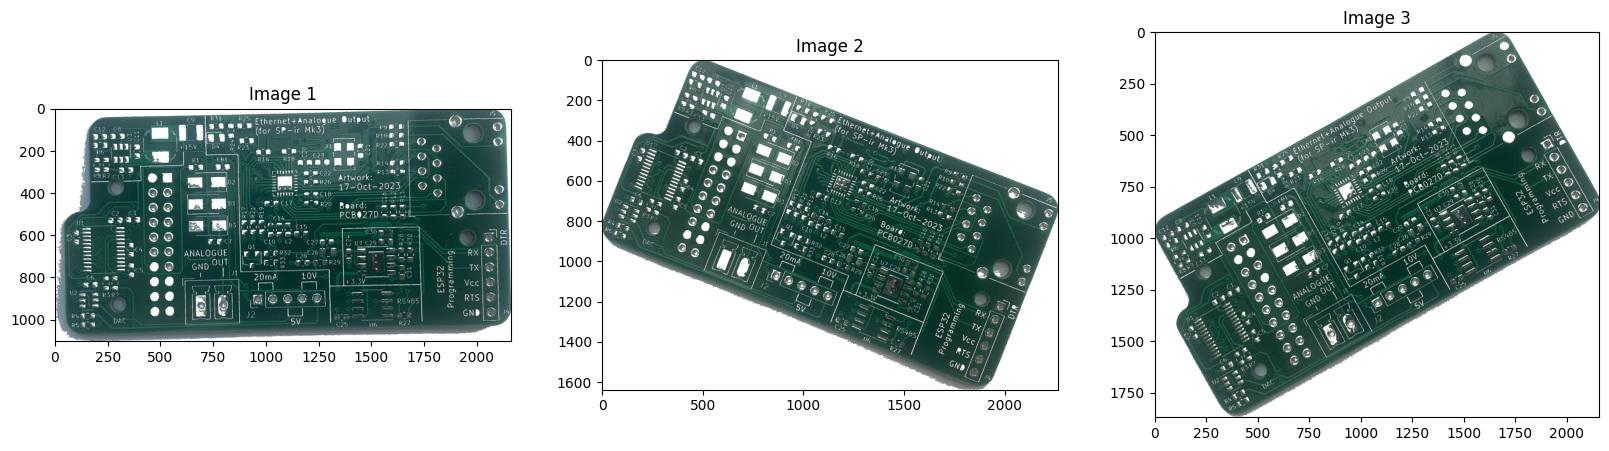

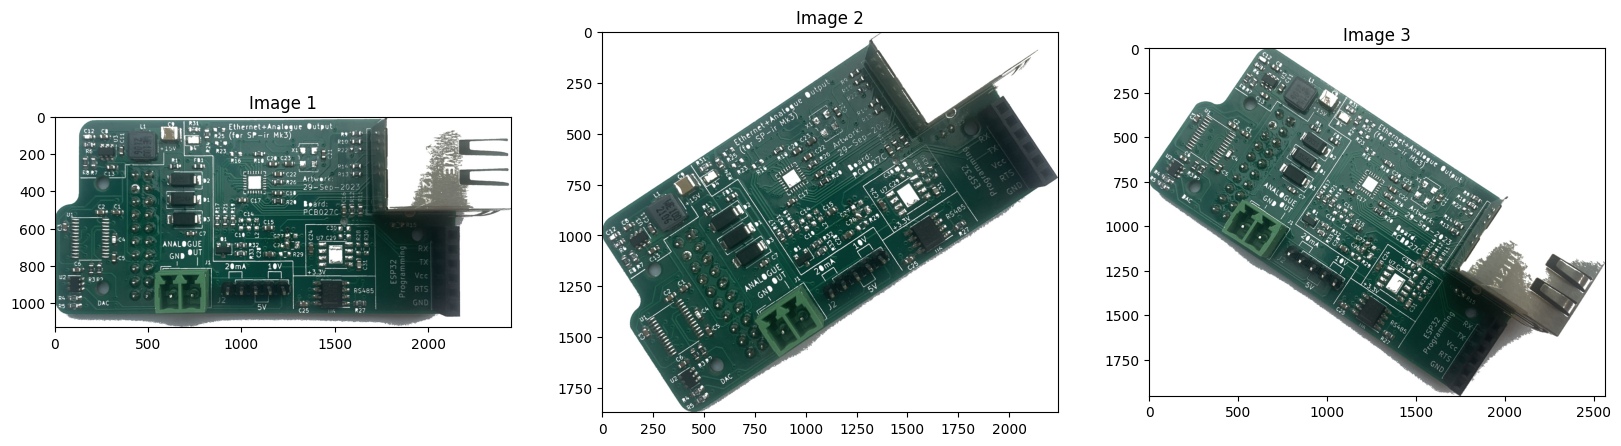

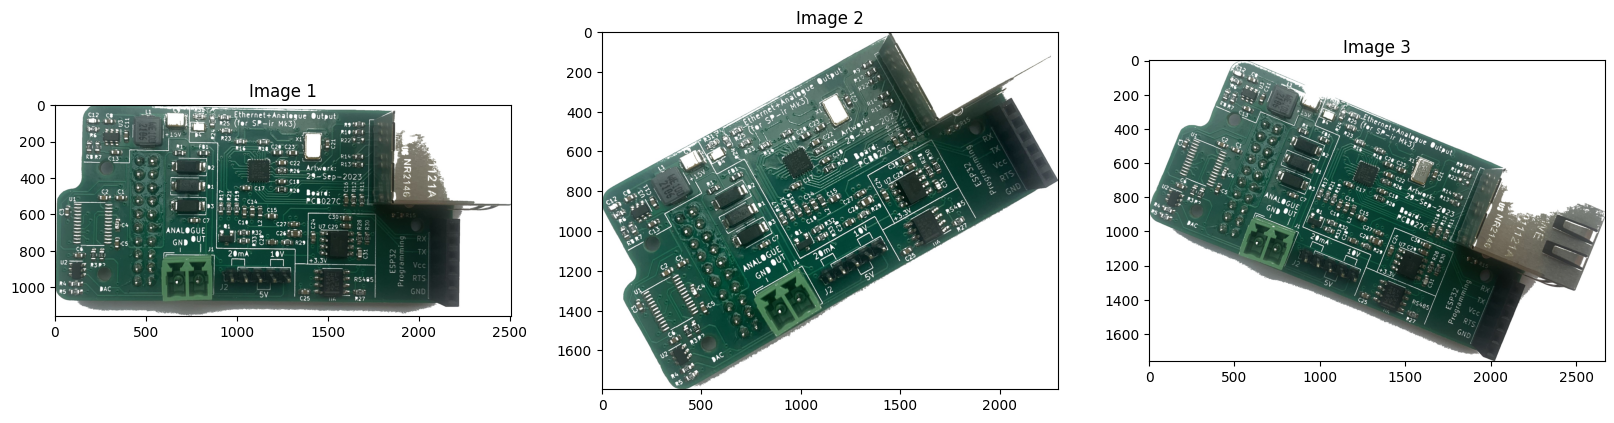

In [8]:
if should_find_components:
    find_components_in_each_board_img()
else:
    read_components_from_cache()

show_images_in_row(board1_singles)
show_images_in_row(board2_singles)
show_images_in_row(board3_singles)

## Scale images to make them have the same size

In [9]:
# Get board2 singles and board3 singles, make each of board3 scaled to the size of board2
board3_singles = tuple(
    cv2.resize(board3_single, (board2_single.shape[1], board2_single.shape[0]))
    for board2_single, board3_single in zip(board2_singles, board3_singles)
)

## Rotate images manually

In [10]:
board2_singles = tuple([
    board2_singles[0],
    rotate_img_by_angle(board2_singles[1], -3),
    rotate_img_by_angle(board2_singles[2], 8),
])

## Use `absdiff` to find differences

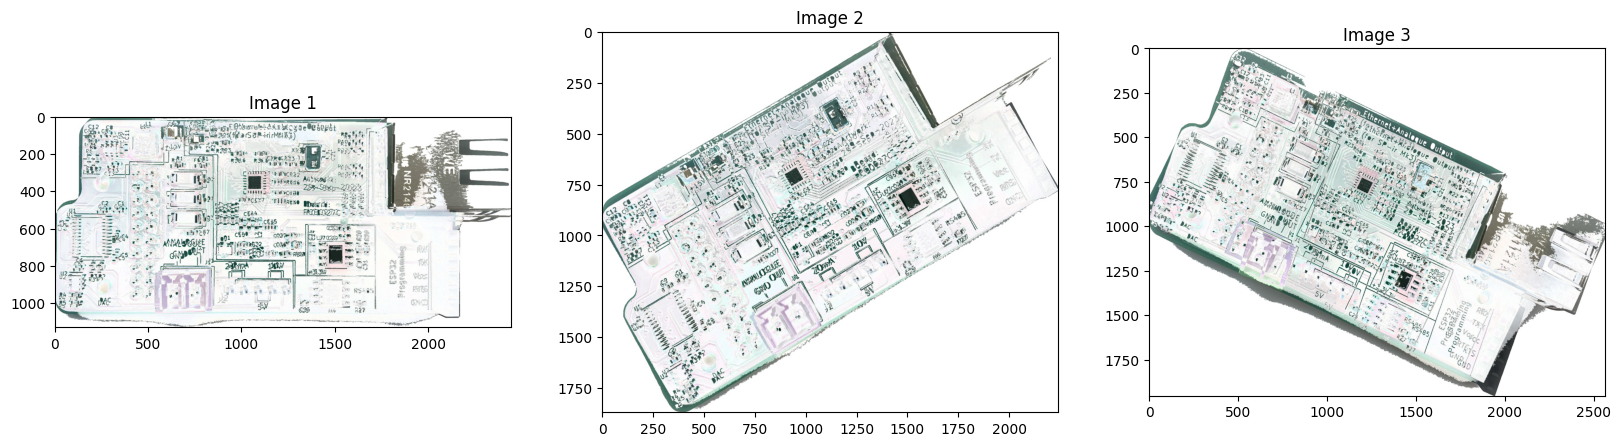

In [11]:
diffs = tuple(
    255 - cv2.absdiff(board2_single, board3_single)
    for board2_single, board3_single in zip(board2_singles, board3_singles)
)

show_images_in_row(diffs)

## Show diff histograms

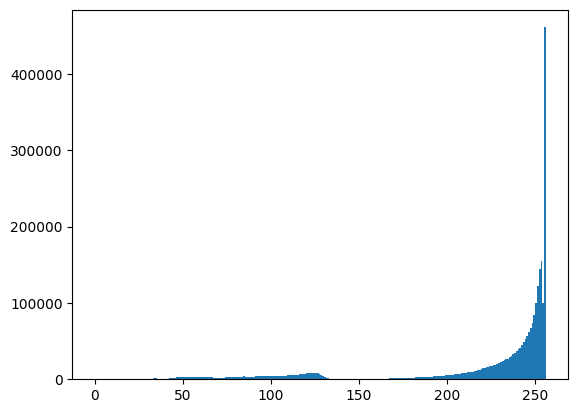

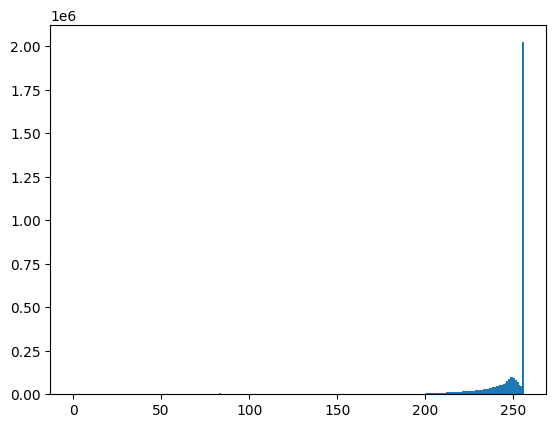

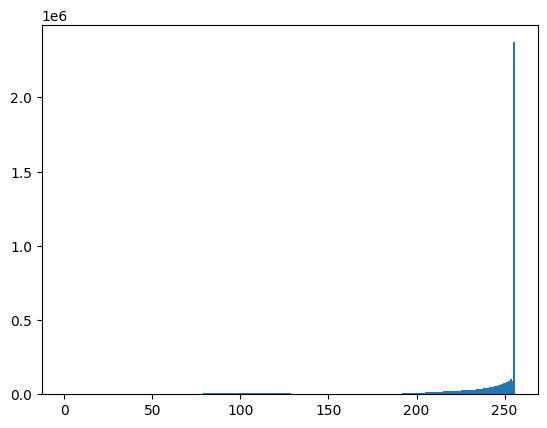

In [12]:
# Convert diffs to gray images
gray_diffs = tuple(
    cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)
    for diff in diffs
)

# show each of their histograms
for gray_diff in gray_diffs:
    plt.hist(gray_diff.ravel(), bins=256, range=(0, 256))
    plt.show()

# Filter areas in diffs

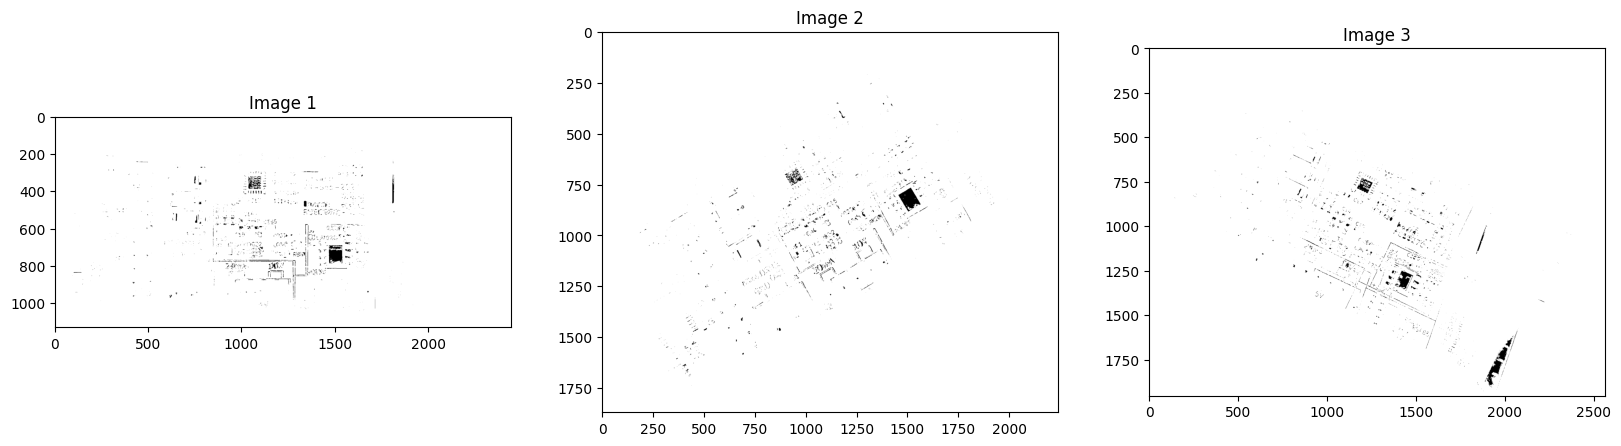

In [14]:
diff_threshold = 50

filtered_gray_diffs = tuple(
    gray_diff.copy()
    for gray_diff in gray_diffs
)

for filtered_gray_diff in filtered_gray_diffs:
    filtered_gray_diff[filtered_gray_diff < diff_threshold] = 0
    filtered_gray_diff[filtered_gray_diff >= diff_threshold] = 255
    
show_images_in_row(filtered_gray_diffs, is_gray=True)